In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
nest_asyncio.apply()# must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union


In [3]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'

In [4]:
%pwd

'/host_home/nuplan-devkit/henry_experiments'

In [5]:
# Location of path with all simulation configs
SAVE_DIR = Path('/home/ehdykhne/nuplan-devkit/henry_experiments') / 'relavance_construction'  # optionally replace with persistent dir


CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

CHECKPOINT_PATH='pretrained_checkpoints/gc_pgp_checkpoint.ckpt'

# Select the planner and simulation challenge
PLANNER = 'ml_planner'  # [simple_planner, ml_planner]
CHALLENGE = 'closed_loop_reactive_agents'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
#    'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.scenario_types=[starting_unprotected_cross_turn]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=1',  # use 1 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'simulation_simple_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'planner={PLANNER}',
    f'model=gc_pgp_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={CHECKPOINT_PATH}',  # this path can be replaced by the checkpoint of the model trained in the previous section
#     f'observation={OBSERVATION}',
#     'observation.model_config=${model}',
#     f'observation.checkpoint_path={CHECKPOINT_PATH}',
    f'group={SAVE_DIR}',
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
    'hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]'
])

# The following set of cells holds the files nescesary to start and run the simulation

## function for plotting the relavance images

In [6]:
import matplotlib.pyplot as plt
def plot_relavance(plot_name, single_polygon, polygons):

    # Calculate intersections and plot
    fig, ax = plt.subplots()

    # Plotting list of polygons in green
    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, color='green', alpha=0.5)

    # Plotting single polygon in blue
    x, y = single_polygon.exterior.xy
    ax.fill(x, y, color='blue', alpha=0.5)

    # Finding intersections and plotting in red
    intersections = []
    for poly in polygons:
        intersection = poly.intersection(single_polygon)
        if intersection.is_empty:
            continue
        if intersection.geom_type == 'Polygon':
            x, y = intersection.exterior.xy
            ax.fill(x, y, color='red', alpha=0.5)
        elif intersection.geom_type == 'MultiPolygon':
            for inter_poly in intersection:
                x, y = inter_poly.exterior.xy
                ax.fill(x, y, color='red', alpha=0.5)

    # Save the plot
    plt.savefig('plots/relavance/'+plot_name)

## simulations_runner.py

In [7]:
from __future__ import annotations

import logging
import time
from typing import Any, Callable, List

from nuplan.planning.scenario_builder.abstract_scenario import AbstractScenario
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner
from nuplan.planning.simulation.runner.abstract_runner import AbstractRunner
from nuplan.planning.simulation.runner.runner_report import RunnerReport
from nuplan.planning.simulation.simulation import Simulation
##
from nuplan.common.actor_state.tracked_objects import TrackedObject, TrackedObjects, TrackedObjectType
from nuplan.common.actor_state.tracked_objects_types import AGENT_TYPES, STATIC_OBJECT_TYPES, TrackedObjectType
from shapely.geometry import Point, LineString, Polygon
##

logger = logging.getLogger(__name__)


def for_each(fn: Callable[[Any], Any], items: List[Any]) -> None:
    """
    Call function on every item in items
    :param fn: function to be called fn(item)
    :param items: list of items
    """
    for item in items:
        fn(item)


class SimulationRunner(AbstractRunner):
    """
    Manager which executes multiple simulations with the same planner
    """

    def __init__(self, simulation: Simulation, planner: AbstractPlanner):
        """
        Initialize the simulations manager
        :param simulation: Simulation which will be executed
        :param planner: to be used to compute the desired ego's trajectory
        """
        self._simulation = simulation
        self._planner = planner
        ##
        self._simulation._scenario.initial_tracked_objects.tracked_objects
        scenario = self._simulation._scenario
        
        #we only grab the initial track tokens but we could also grab all of them, or from the window that starts at the current iteration till the end, or to some preselected future time horizon
        initial_vehicle_track_tokens = {
            tracked_object.track_token
            for tracked_object in scenario.initial_tracked_objects.tracked_objects
            if tracked_object.tracked_object_type == TrackedObjectType.VEHICLE
        }
        print('intitial_track_tokens', initial_vehicle_track_tokens)
        
        # returns the tracks for all the vehicles for the entire scenario
        iteration_looking_from = 0
        future_horizon = scenario.get_number_of_iterations() - 1 - iteration_looking_from
        obs_veh_traj = scenario.get_tracked_objects_within_time_window_at_iteration(iteration = 0,
                                                            past_time_horizon = 0,
                                                            future_time_horizon = future_horizon)
#                                                             filter_track_tokens = initial_vehicle_track_tokens)
        print('hi there')
        vehicles_future_tracks = {track_token: [] for track_token in initial_vehicle_track_tokens}
        
        # This bit filters the returned tracks to just the initial ones. we do this because using the filter sometimes causes SQL errors? Maybe we should try again.
        # it also collects the tracks by token
        for tracked_object in obs_veh_traj.tracked_objects:
            if tracked_object.track_token in initial_vehicle_track_tokens:
                vehicles_future_tracks[tracked_object.track_token].append((tracked_object.center.x, tracked_object.center.y))

        
        vehicles_future_linestrings_buffered = {}
        #we convert the tracks to a linestring with a buffer in order to be able to check for intersections later with the ego trajectory
        for token in vehicles_future_tracks.keys():
            vehicles_future_linestrings_buffered[token] = LineString(vehicles_future_tracks[token]).buffer(1)
        print('linestring stuff')
            
        ego_traj_gen = scenario._extract_expert_trajectory()
        ego_future_track = [(state.center.x, state.center.y) for state in ego_traj_gen]
        ego_future_track_buffered = LineString(ego_future_track).buffer(1)
        
        #now we check if ego traj intersects with each agent traj to determine which is relavant
        relavant_agent_tokens = []
        for token in vehicles_future_linestrings_buffered.keys():
            if ego_future_track_buffered.intersects(vehicles_future_linestrings_buffered[token]):
                relavant_agent_tokens.append(token)
        
        
#         print('vehicle traj', vehicles_future_tracks)
#         print('ego traj', ego_future_tracks)
        print('relavant', relavant_agent_tokens)
        plot_relavance('scenario_'+scenario.token, ego_future_track_buffered, vehicles_future_linestrings_buffered.values())
        
        exit()
        ##

    def _initialize(self) -> None:
        """
        Initialize the planner
        """
        # Execute specific callback
        self._simulation.callback.on_initialization_start(self._simulation.setup, self.planner)

        # Initialize Planner
        self.planner.initialize(self._simulation.initialize())

        # Execute specific callback
        self._simulation.callback.on_initialization_end(self._simulation.setup, self.planner)

    @property
    def planner(self) -> AbstractPlanner:
        """
        :return: Planner used by the SimulationRunner
        """
        return self._planner

    @property
    def simulation(self) -> Simulation:
        """
        :return: Simulation used by the SimulationRunner
        """
        return self._simulation

    @property
    def scenario(self) -> AbstractScenario:
        """
        :return: Get the scenario relative to the simulation.
        """
        return self.simulation.scenario

    def run(self) -> RunnerReport:
        """
        Run through all simulations. The steps of execution follow:
         - Initialize all planners
         - Step through simulations until there no running simulation
        :return: List of SimulationReports containing the results of each simulation
        """
        start_time = time.perf_counter()

        # Initialize reports for all the simulations that will run
        report = RunnerReport(
            succeeded=True,
            error_message=None,
            start_time=start_time,
            end_time=None,
            planner_report=None,
            scenario_name=self._simulation.scenario.scenario_name,
            planner_name=self.planner.name(),
            log_name=self._simulation.scenario.log_name,
        )
        
        self.simulation

        # Execute specific callback
        self.simulation.callback.on_simulation_start(self.simulation.setup)

        # Initialize all simulations
        self._initialize()

        while self.simulation.is_simulation_running():
            # Execute specific callback
            self.simulation.callback.on_step_start(self.simulation.setup, self.planner)

            # Perform step
            planner_input = self._simulation.get_planner_input()
            logger.debug("Simulation iterations: %s" % planner_input.iteration.index)

            # Execute specific callback
            self._simulation.callback.on_planner_start(self.simulation.setup, self.planner)

            # Plan path based on all planner's inputs
            trajectory = self.planner.compute_trajectory(planner_input)

            # Propagate simulation based on planner trajectory
            self._simulation.callback.on_planner_end(self.simulation.setup, self.planner, trajectory)
            self.simulation.propagate(trajectory)

            # Execute specific callback
            self.simulation.callback.on_step_end(self.simulation.setup, self.planner, self.simulation.history.last())

            # Store reports for simulations which just finished running
            current_time = time.perf_counter()
            if not self.simulation.is_simulation_running():
                report.end_time = current_time

        # Execute specific callback
        self.simulation.callback.on_simulation_end(self.simulation.setup, self.planner, self.simulation.history)

        planner_report = self.planner.generate_planner_report()
        report.planner_report = planner_report

        return report


## executor.py

In [8]:
import concurrent.futures
import logging
import time
import traceback
from typing import Dict, List, Optional, Tuple, Union

from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.simulation_log_callback import SimulationLogCallback
from nuplan.planning.simulation.runner.abstract_runner import AbstractRunner
from nuplan.planning.simulation.runner.runner_report import RunnerReport
# from nuplan.planning.simulation.runner.simulations_runner import SimulationRunner
from nuplan.planning.utils.multithreading.worker_pool import Task, WorkerPool

logger = logging.getLogger(__name__)


def run_simulation(sim_runner: AbstractRunner, exit_on_failure: bool = False) -> RunnerReport:
    """
    Proxy for calling simulation.
    :param sim_runner: A simulation runner which will execute all batched simulations.
    :param exit_on_failure: If true, raises an exception when the simulation fails.
    :return report for the simulation.
    """
    # Store start time so that if the simulations fail, we know how long they ran for
    start_time = time.perf_counter()
    
    try:
        return sim_runner.run()
    except Exception as e:
        error = traceback.format_exc()

        # Print to the terminal
        logger.warning("----------- Simulation failed: with the following trace:")
        traceback.print_exc()
        logger.warning(f"Simulation failed with error:\n {e}")

        # Log the failed scenario log/tokens
        failed_scenarios = f"[{sim_runner.scenario.log_name}, {sim_runner.scenario.scenario_name}]\n"
        logger.warning(f"\nFailed simulation [log,token]:\n {failed_scenarios}")

        logger.warning("----------- Simulation failed!")

        # Fail if desired
        if exit_on_failure:
            raise RuntimeError('Simulation failed')

        end_time = time.perf_counter()
        report = RunnerReport(
            succeeded=False,
            error_message=error,
            start_time=start_time,
            end_time=end_time,
            planner_report=None,
            scenario_name=sim_runner.scenario.scenario_name,
            planner_name=sim_runner.planner.name(),
            log_name=sim_runner.scenario.log_name,
        )

        return report


def execute_runners(
    runners: List[AbstractRunner],
    worker: WorkerPool,
    num_gpus: Optional[Union[int, float]],
    num_cpus: Optional[int],
    exit_on_failure: bool = False,
    verbose: bool = False,
) -> List[RunnerReport]:
    """
    Execute multiple simulation runners or metric runners.
    :param runners: A list of simulations to be run.
    :param worker: for submitting tasks.
    :param num_gpus: if None, no GPU will be used, otherwise number (also fractional) of GPU used per simulation.
    :param num_cpus: if None, all available CPU threads are used, otherwise number of threads used.
    :param exit_on_failure: If true, raises an exception when the simulation fails.
    """
    # Validating
    assert len(runners) > 0, 'No scenarios found to simulate!'

    # Start simulations
    number_of_sims = len(runners)
    logger.info(f"Starting {number_of_sims} simulations using {worker.__class__.__name__}!")
    print('about to start all the runners')
    reports: List[RunnerReport] = worker.map(
        Task(fn=run_simulation, num_gpus=num_gpus, num_cpus=num_cpus), runners, exit_on_failure, verbose=verbose
    )
    # Store the results in a dictionary so we can easily store error tracebacks in the next step, if needed
    results: Dict[Tuple[str, str, str], RunnerReport] = {
        (report.scenario_name, report.planner_name, report.log_name): report for report in reports
    }

    # Iterate over runners, finding the callbacks which may have run asynchronously, and gathering their results
    simulations_runners = (runner for runner in runners if isinstance(runner, SimulationRunner))
    relevant_simulations = ((runner.simulation, runner) for runner in simulations_runners)
    callback_futures_lists = (
        (callback.futures, simulation, runner)
        for (simulation, runner) in relevant_simulations
        for callback in simulation.callback.callbacks
        if isinstance(callback, MetricCallback) or isinstance(callback, SimulationLogCallback)
    )
    callback_futures_map = {
        future: (simulation.scenario.scenario_name, runner.planner.name(), simulation.scenario.log_name)
        for (futures, simulation, runner) in callback_futures_lists
        for future in futures
    }
    for future in concurrent.futures.as_completed(callback_futures_map.keys()):
        try:
            future.result()
        except Exception:
            error_message = traceback.format_exc()
            runner_report = results[callback_futures_map[future]]
            runner_report.error_message = error_message
            runner_report.succeeded = False
            runner_report.end_time = time.perf_counter()

    # Notify user about the result of simulations
    failed_simulations = str()
    number_of_successful = 0
    runner_reports: List[RunnerReport] = list(results.values())
    for result in runner_reports:
        if result.succeeded:
            number_of_successful += 1
        else:
            logger.warning("Failed Simulation.\n '%s'", result.error_message)
            failed_simulations += f"[{result.log_name}, {result.scenario_name}] \n"

    number_of_failures = number_of_sims - number_of_successful
    logger.info(f"Number of successful simulations: {number_of_successful}")
    logger.info(f"Number of failed simulations: {number_of_failures}")

    # Print out all failed simulation unique identifier
    if number_of_failures > 0:
        logger.info(f"Failed simulations [log, token]:\n{failed_simulations}")

    return runner_reports


## utils.py

In [9]:
import logging
import os
from dataclasses import dataclass
from pathlib import Path
from typing import List

import pandas as pd
from omegaconf import DictConfig

from nuplan.common.utils.file_backed_barrier import distributed_sync
from nuplan.common.utils.io_utils import safe_path_to_string
from nuplan.planning.script.builders.folder_builder import build_simulation_experiment_folder
from nuplan.planning.script.builders.logging_builder import build_logger
from nuplan.planning.script.builders.main_callback_builder import build_main_multi_callback
from nuplan.planning.script.builders.utils.utils_config import update_config_for_simulation
from nuplan.planning.script.builders.worker_pool_builder import build_worker
from nuplan.planning.simulation.main_callback.multi_main_callback import MultiMainCallback
from nuplan.planning.simulation.runner.abstract_runner import AbstractRunner
# from nuplan.planning.simulation.runner.executor import execute_runners
from nuplan.planning.simulation.runner.runner_report import RunnerReport
from nuplan.planning.training.callbacks.profile_callback import ProfileCallback
from nuplan.planning.utils.multithreading.worker_pool import WorkerPool

logger = logging.getLogger(__name__)

DEFAULT_DATA_ROOT = os.path.expanduser('~/nuplan/dataset')
DEFAULT_EXP_ROOT = os.path.expanduser('~/nuplan/exp')


@dataclass
class CommonBuilder:
    """Common builder data."""

    worker: WorkerPool
    multi_main_callback: MultiMainCallback
    output_dir: Path
    profiler: ProfileCallback


def set_default_path() -> None:
    """
    This function sets the default paths as environment variables if none are set.
    These can then be used by Hydra, unless the user overwrites them from the command line.
    """
    if 'NUPLAN_DATA_ROOT' not in os.environ:
        logger.info(f'Setting default NUPLAN_DATA_ROOT: {DEFAULT_DATA_ROOT}')
        os.environ['NUPLAN_DATA_ROOT'] = DEFAULT_DATA_ROOT

    if 'NUPLAN_EXP_ROOT' not in os.environ:
        logger.info(f'Setting default NUPLAN_EXP_ROOT: {DEFAULT_EXP_ROOT}')
        os.environ['NUPLAN_EXP_ROOT'] = DEFAULT_EXP_ROOT


def save_runner_reports(reports: List[RunnerReport], output_dir: Path, report_name: str) -> None:
    """
    Save runner reports to a parquet file in the output directory.
    Output directory can be local or s3.
    :param reports: Runner reports returned from each simulation.
    :param output_dir: Output directory to save the report.
    :param report_name: Report name.
    """
    report_dicts = []
    for report in map(lambda x: x.__dict__, reports):  # type: ignore
        if (planner_report := report["planner_report"]) is not None:
            planner_report_statistics = planner_report.compute_summary_statistics()
            del report["planner_report"]
            report.update(planner_report_statistics)
        report_dicts.append(report)
    df = pd.DataFrame(report_dicts)
    df['duration'] = df['end_time'] - df['start_time']

    save_path = output_dir / report_name
    df.to_parquet(safe_path_to_string(save_path))
    logger.info(f'Saved runner reports to {save_path}')


def set_up_common_builder(cfg: DictConfig, profiler_name: str) -> CommonBuilder:
    """
    Set up a common builder when running simulations.
    :param cfg: Hydra configuration.
    :param profiler_name: Profiler name.
    :return A data classes with common builders.
    """
    # Build multi main callback
    multi_main_callback = build_main_multi_callback(cfg)

    # After run_simulation start
    multi_main_callback.on_run_simulation_start()

    # Update and override configs for simulation
    update_config_for_simulation(cfg=cfg)

    # Configure logger
    build_logger(cfg)

    # Construct builder
    worker = build_worker(cfg)

    # Create output storage folder
    build_simulation_experiment_folder(cfg=cfg)

    # Simulation Callbacks
    output_dir = Path(cfg.output_dir)

    # Create profiler if enabled
    profiler = None
    if cfg.enable_profiling:
        logger.info('Profiler is enabled!')
        profiler = ProfileCallback(output_dir=output_dir)

    if profiler:
        # Profile the simulation construction
        profiler.start_profiler(profiler_name)

    return CommonBuilder(
        worker=worker,
        multi_main_callback=multi_main_callback,
        output_dir=output_dir,
        profiler=profiler,
    )


def run_runners(
    runners: List[AbstractRunner], common_builder: CommonBuilder, profiler_name: str, cfg: DictConfig
) -> None:
    """
    Run a list of runners.
    :param runners: A list of runners.
    :param common_builder: Common builder.
    :param profiler_name: Profiler name.
    :param cfg: Hydra config.
    """
    assert len(runners) > 0, 'No scenarios found to simulate!'
    if common_builder.profiler:
        # Start simulation running profiling
        common_builder.profiler.start_profiler(profiler_name)

    logger.info('Executing runners...')
    reports = execute_runners(
        runners=runners,
        worker=common_builder.worker,
        num_gpus=cfg.number_of_gpus_allocated_per_simulation,
        num_cpus=cfg.number_of_cpus_allocated_per_simulation,
        exit_on_failure=cfg.exit_on_failure,
        verbose=cfg.verbose,
    )
    logger.info('Finished executing runners!')

    # Save RunnerReports as parquet file
    save_runner_reports(reports, common_builder.output_dir, cfg.runner_report_file)

    # Sync up nodes when running distributed simulation
    distributed_sync(Path(cfg.output_dir / Path("barrier")), cfg.distributed_timeout_seconds)

    # Only run on_run_simulation_end callbacks on master node
    if int(os.environ.get('NODE_RANK', 0)) == 0:
        common_builder.multi_main_callback.on_run_simulation_end()

    # Save profiler
    if common_builder.profiler:
        common_builder.profiler.save_profiler(profiler_name)


## simulation_builder.py

In [10]:
import logging
import os
from typing import List, Optional

from hydra.utils import instantiate
from omegaconf import DictConfig

from nuplan.common.utils.distributed_scenario_filter import DistributedMode, DistributedScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.script.builders.metric_builder import build_metrics_engines
from nuplan.planning.script.builders.observation_builder import build_observations
from nuplan.planning.script.builders.planner_builder import build_planners
from nuplan.planning.script.builders.utils.utils_type import is_target_type
from nuplan.planning.simulation.callback.abstract_callback import AbstractCallback
from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.multi_callback import MultiCallback
from nuplan.planning.simulation.controller.abstract_controller import AbstractEgoController
from nuplan.planning.simulation.observation.abstract_observation import AbstractObservation
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner
# from nuplan.planning.simulation.runner.simulations_runner import SimulationRunner
from nuplan.planning.simulation.simulation import Simulation
from nuplan.planning.simulation.simulation_setup import SimulationSetup
from nuplan.planning.simulation.simulation_time_controller.abstract_simulation_time_controller import (
    AbstractSimulationTimeController,
)
from nuplan.planning.utils.multithreading.worker_pool import WorkerPool

logger = logging.getLogger(__name__)


def build_simulations(
    cfg: DictConfig,
    worker: WorkerPool,
    callbacks: List[AbstractCallback],
    callbacks_worker: Optional[WorkerPool] = None,
    pre_built_planners: Optional[List[AbstractPlanner]] = None,
) -> List[SimulationRunner]:
    """
    Build simulations.
    :param cfg: DictConfig. Configuration that is used to run the experiment.
    :param callbacks: Callbacks for simulation.
    :param worker: Worker for job execution.
    :param callbacks_worker: worker pool to use for callbacks from sim
    :param pre_built_planners: List of pre-built planners to run in simulation.
    :return A dict of simulation engines with challenge names.
    """
    logger.info('Building simulations...')

    # Create Simulation object container
    simulations = list()

    # Retrieve scenarios
    logger.info('Extracting scenarios...')

    # Only allow simulation with NuPlanScenarioBuilder except when the NUPLAN_SIMULATION_ALLOW_ANY_BUILDER environment variable is set to a non-zero value.
    if not int(os.environ.get("NUPLAN_SIMULATION_ALLOW_ANY_BUILDER", "0")) and not is_target_type(
        cfg.scenario_builder, NuPlanScenarioBuilder
    ):
        raise ValueError(f"Simulation framework only runs with NuPlanScenarioBuilder. Got {cfg.scenario_builder}")

    scenario_filter = DistributedScenarioFilter(
        cfg=cfg,
        worker=worker,
        node_rank=int(os.environ.get("NODE_RANK", 0)),
        num_nodes=int(os.environ.get("NUM_NODES", 1)),
        synchronization_path=cfg.output_dir,
        timeout_seconds=cfg.distributed_timeout_seconds,
        distributed_mode=DistributedMode[cfg.distributed_mode],
    )
    scenarios = scenario_filter.get_scenarios()

    metric_engines_map = {}
    if cfg.run_metric:
        logger.info('Building metric engines...')
        metric_engines_map = build_metrics_engines(cfg=cfg, scenarios=scenarios)
        logger.info('Building metric engines...DONE')
    else:
        logger.info('Metric engine is disable')

    logger.info('Building simulations from %d scenarios...', len(scenarios))

    # Build a metric metadata file
    for scenario in scenarios:

        # Build planners
        if pre_built_planners is None:
            if 'planner' not in cfg.keys():
                raise KeyError('Planner not specified in config. Please specify a planner using "planner" field.')

            planners = build_planners(cfg.planner, scenario)
        else:
            planners = pre_built_planners

        for planner in planners:
            # Ego Controller
            ego_controller: AbstractEgoController = instantiate(cfg.ego_controller, scenario=scenario)

            # Simulation Manager
            simulation_time_controller: AbstractSimulationTimeController = instantiate(
                cfg.simulation_time_controller, scenario=scenario
            )

            # Perception
            observations: AbstractObservation = build_observations(cfg.observation, scenario=scenario)

            # Metric Engine
            metric_engine = metric_engines_map.get(scenario.scenario_type, None)
            if metric_engine is not None:
                stateful_callbacks = [MetricCallback(metric_engine=metric_engine, worker_pool=callbacks_worker)]
            else:
                stateful_callbacks = []

            if "simulation_log_callback" in cfg.callback:
                stateful_callbacks.append(
                    instantiate(cfg.callback["simulation_log_callback"], worker_pool=callbacks_worker)
                )

            # Construct simulation and manager
            simulation_setup = SimulationSetup(
                time_controller=simulation_time_controller,
                observations=observations,
                ego_controller=ego_controller,
                scenario=scenario,
            )

            simulation = Simulation(
                simulation_setup=simulation_setup,
                callback=MultiCallback(callbacks + stateful_callbacks),
                simulation_history_buffer_duration=cfg.simulation_history_buffer_duration,
            )
            simulations.append(SimulationRunner(simulation, planner))

    logger.info('Building simulations...DONE!')
    return simulations

## run_simulation.py

In [11]:
import logging
import os
from pathlib import Path
from shutil import rmtree
from typing import List, Optional, Union

import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
# from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
# from utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'


def run_simulation_main(cfg: DictConfig, planners: Optional[Union[AbstractPlanner, List[AbstractPlanner]]] = None) -> None:
    """
    Execute all available challenges simultaneously on the same scenario. Helper function for main to allow planner to
    be specified via config or directly passed as argument.
    :param cfg: Configuration that is used to run the experiment.
        Already contains the changes merged from the experiment's config to default config.
    :param planners: Pre-built planner(s) to run in simulation. Can either be a single planner or list of planners.
    """
    # Fix random seed
    pl.seed_everything(cfg.seed, workers=True)

    profiler_name = 'building_simulation'
    common_builder = set_up_common_builder(cfg=cfg, profiler_name=profiler_name)

    # Build simulation callbacks
    callbacks_worker_pool = build_callbacks_worker(cfg)
    callbacks = build_simulation_callbacks(cfg=cfg, output_dir=common_builder.output_dir, worker=callbacks_worker_pool)

    # Remove planner from config to make sure run_simulation does not receive multiple planner specifications.
    if planners and 'planner' in cfg.keys():
        logger.info('Using pre-instantiated planner. Ignoring planner in config')
        OmegaConf.set_struct(cfg, False)
        cfg.pop('planner')
        OmegaConf.set_struct(cfg, True)

    # Construct simulations
    if isinstance(planners, AbstractPlanner):
        planners = [planners]

    runners = build_simulations(
        cfg=cfg,
        callbacks=callbacks,
        worker=common_builder.worker,
        pre_built_planners=planners,
        callbacks_worker=callbacks_worker_pool,
    )

    if common_builder.profiler:
        # Stop simulation construction profiling
        common_builder.profiler.save_profiler(profiler_name)

    logger.info('Running simulation...')
    run_runners(runners=runners, common_builder=common_builder, cfg=cfg, profiler_name='running_simulation')
    logger.info('Finished running simulation!')


def clean_up_s3_artifacts() -> None:
    """
    Cleanup lingering s3 artifacts that are written locally.
    This happens because some minor write-to-s3 functionality isn't yet implemented.
    """
    # Lingering artifacts get written locally to a 's3:' directory. Hydra changes
    # the working directory to a subdirectory of this, so we serach the working
    # path for it.
    working_path = os.getcwd()
    s3_dirname = "s3:"
    s3_ind = working_path.find(s3_dirname)
    if s3_ind != -1:
        local_s3_path = working_path[: working_path.find(s3_dirname) + len(s3_dirname)]
        rmtree(local_s3_path)


@hydra.main(config_path=CONFIG_PATH, config_name=CONFIG_NAME)
def main(cfg: DictConfig) -> None:
    """
    Execute all available challenges simultaneously on the same scenario. Calls run_simulation to allow planner to
    be specified via config or directly passed as argument.
    :param cfg: Configuration that is used to run the experiment.
        Already contains the changes merged from the experiment's config to default config.
    """
    assert cfg.simulation_log_main_path is None, 'Simulation_log_main_path must not be set when running simulation.'
    # Execute simulation with preconfigured planner(s).
    run_simulation_main(cfg=cfg)

#     if is_s3_path(Path(cfg.output_dir)):
#         clean_up_s3_artifacts()


# if __name__ == '__main__':
#     main()


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-11-25 08:23:26,026 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-11-25 08:23:26,087 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-11-25 08:23:28,275	INFO worker.py:1673 -- Started a local Ray instance.


2023-11-25 08:23:31,433 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-11-25 08:23:31,433 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 1
Number of threads across all nodes: 32
2023-11-25 08:23:31,433 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-11-25 08:23:31,433 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-11-25 08:23:31,434 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: /home/ehdykhne/nuplan-devkit/henry_experiments/relavance_construction/simulation_simple_experiment/closed_loop_reactive_agents/2023.11.25.08.23.25

2023-11-25 08:23:31,438 INFO {/home/

Ray objects: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


2023-11-25 08:23:49,820 INFO {/tmp/ipykernel_81094/2130110447.py:74}  Building metric engines...
2023-11-25 08:23:49,865 INFO {/tmp/ipykernel_81094/2130110447.py:76}  Building metric engines...DONE
2023-11-25 08:23:49,865 INFO {/tmp/ipykernel_81094/2130110447.py:80}  Building simulations from 1 scenarios...
2023-11-25 08:23:49,869 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-11-25 08:23:50,089 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
intitial_track_tokens {'105f4ecbf9d05853', '6e0f1dbf087e570f', '902071762c5e5e01', '4e86a1acfa645707', '60ca1d120e62535e', 'bd2464341e2d514e', 'dbfa8805c3e5513a', 'b1cd7cefda4554c1', '5b2a02f606095295', '457624c0d9955ea9', 'de2d3da47a925987', '8159b45800b859f8', 'df0570f53b805830', '31d2709a75d4505d', '1f935c796c4e5258', '50387432e4d8599d', '00e33d623d775f9a', '108e078384b05d3f', '22396925142850

Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 781, in ray._raylet.prepare_args_internal
  File "/opt/conda/lib/python3.9/site-packages/ray/_private/serialization.py", line 494, in serialize
    return self._serialize_to_msgpack(value)
  File "/opt/conda/lib/python3.9/site-packages/ray/_private/serialization.py", line 472, in _serialize_to_msgpack
    pickle5_serialized_object = self._serialize_to_pickle5(
  File "/opt/conda/lib/python3.9/site-packages/ray/_private/serialization.py", line 425, in _serialize_to_pickle5
    raise e
  File "/opt/conda/lib/python3.9/site-packages/ray/_private/serialization.py", line 420, in _serialize_to_pickle5
    inband = pickle.dumps(
  File "/opt/conda/lib/python3.9/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 88, in dumps
    cp.dump(obj)
  File "/opt/conda/lib/python3.9/site-packages/ray/cloudpickle/cloudpickle_fast.py", line 733, in dump
    return Pickler.dump(self, obj)
  File "stringsource", line 2, in zmq.b

RuntimeError: Could not serialize the argument <__main__.SimulationRunner object at 0x7faceb9e6160> for a task or actor nuplan.planning.utils.multithreading.ray_execution.wrap_function.<locals>.wrapped_fn:
================================================================================
Checking Serializability of <__main__.SimulationRunner object at 0x7faceb9e6160>
================================================================================
[31m!!! FAIL[39m serialization: no default __reduce__ due to non-trivial __cinit__
    Serializing '_abc_impl' <_abc._abc_data object at 0x7facab9b7c80>...
    [31m!!! FAIL[39m serialization: cannot pickle '_abc._abc_data' object
    WARNING: Did not find non-serializable object in <_abc._abc_data object at 0x7facab9b7c80>. This may be an oversight.
================================================================================
Variable: 

	[1mFailTuple(_abc_impl [obj=<_abc._abc_data object at 0x7facab9b7c80>, parent=<__main__.SimulationRunner object at 0x7faceb9e6160>])[0m

was found to be non-serializable. There may be multiple other undetected variables that were non-serializable. 
Consider either removing the instantiation/imports of these variables or moving the instantiation into the scope of the function/class. 
================================================================================
Check https://docs.ray.io/en/master/ray-core/objects/serialization.html#troubleshooting for more information.
If you have any suggestions on how to improve this error message, please reach out to the Ray developers on github.com/ray-project/ray/issues/
================================================================================


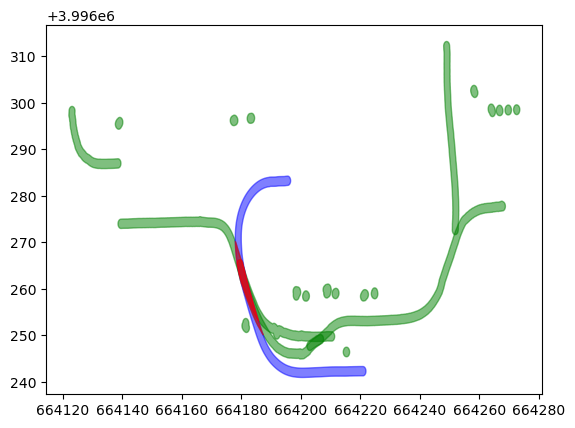

In [12]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

In [ ]:
# from nuplan.planning.script.run_simulation import main as main_simulation

# # Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
# main_simulation(cfg)